In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import os
import torchvision.transforms as tr
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pydicom
import glob
import collections
from datetime import datetime
from skimage import measure
from skimage.measure import block_reduce
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.transform import resize
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import seaborn as sns
from collections import defaultdict

In [2]:
pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     |████████████████████████████████| 1637.0 MB 4.5 kB/s  eta 0:00:01    |███▋                            | 187.1 MB 29.3 MB/s eta 0:00:50     |█████▏                          | 265.5 MB 40.6 MB/s eta 0:00:34     |█████▍                          | 274.5 MB 34.6 MB/s eta 0:00:40     |█████▌                          | 279.5 MB 34.6 MB/s eta 0:00:40     |█████▌                          | 281.1 MB 34.6 MB/s eta 0:00:40     |█████▋                          | 284.3 MB 34.6 MB/s eta 0:00:40     |█████▋                          | 287.4 MB 34.6 MB/s eta 0:00:39     |█████▊                          | 295.2 MB 34.6 MB/s eta 0:00:39     |█████▉                          | 296.9 MB 34.6 MB/s eta 0:00:39     |██████                          | 311.3 MB 38.6 MB/s eta 0:00:35     |██████▎                         | 323.6 MB 38.6 MB/s eta 0:00:34     |██████▍                         | 325.3 MB 38.6 MB/s eta 0:00:34     |

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('../input/vinbigdata-chest-xray-abnormalities-detection/train.csv')
df.head(10)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0
8,d3637a1935a905b3c326af31389cb846,Aortic enlargement,0,R10,1329.0,743.0,1521.0,958.0
9,afb6230703512afc370f236e8fe98806,Pulmonary fibrosis,13,R9,1857.0,1607.0,2126.0,2036.0


In [5]:
input_file = os.listdir('../input/vinbigdata-chest-xray-abnormalities-detection/train')
input_files = []
for ip in input_file:
    input_files.append(ip.split('.')[0])

In [6]:
len(input_files)

15000

In [7]:
df[df['image_id']==input_files[3]].sort_values(by=['class_id'])

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
13623,7ecd6f67f649f26c05805c8359f9e528,Pleural thickening,11,R9,1769.0,396.0,2071.0,551.0
13961,7ecd6f67f649f26c05805c8359f9e528,Pulmonary fibrosis,13,R10,748.0,557.0,1099.0,911.0
38156,7ecd6f67f649f26c05805c8359f9e528,Pulmonary fibrosis,13,R9,714.0,597.0,1014.0,830.0
47023,7ecd6f67f649f26c05805c8359f9e528,Pulmonary fibrosis,13,R8,810.0,612.0,1170.0,958.0


In [8]:
class traindataset(torch.utils.data.Dataset):

    def __init__(self, df, file_list, transform):
        super().__init__()
        
        self.file_list = file_list
        self.df = df
    
    def __len__(self) :
        return len(self.file_list)

    def __getitem__(self, idx):
        
        img_id = self.file_list[idx]
        df = self.df
        s = 224
        N = 15
        d_f = df[df['image_id']==img_id]
        dff = d_f.sort_values(by=['class_id'])
        class_id = dff['class_id'].values.tolist()
        img_pxl = pydicom.read_file('../input/vinbigdata-chest-xray-abnormalities-detection/train/'+img_id+'.dicom').pixel_array
        img_res = resize(img_pxl,(s,s),anti_aliasing=True)
        img_np = img_res.astype(np.float32())
        img_tr = torch.from_numpy(img_np)
        x_ = s/img_pxl.shape[1]
        y_ = s/img_pxl.shape[0]
        xmin = [x*x_ for x in dff['x_min'].values.tolist()]
        ymin = [y*y_ for y in dff['y_min'].values.tolist()]
        xmax = [x1*x_ for x1 in dff['x_max'].values.tolist()]
        ymax = [y1*y_ for y1 in dff['y_max'].values.tolist()]
        #bbox = []
        #for z in range(len(xmin)):
        #    bbox.append([xmin[z],ymin[z],xmax[z],ymax[z]])
        mask = np.zeros((N,s,s))
        for k,m in enumerate(class_id):
            if m != 14:
                x1,x2,y1,y2 = int(xmin[k]),int(xmax[k]),int(ymin[k]),int(ymax[k])
                mask[m,y1:y2,x1:x2] = 1
        mask_numpy = mask.astype(np.float32())
        mask_tensor = torch.from_numpy(mask_numpy)
        #mask_tensor = np.transpose(mask_tensor, (2,0,1))
        return img_tr,mask_tensor

In [9]:
traindata = traindataset(file_list = input_files,df =df,transform = None)
data_loader = torch.utils.data.DataLoader(traindata, batch_size=1, shuffle=True, num_workers=1)

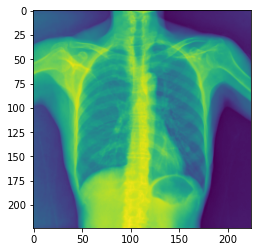

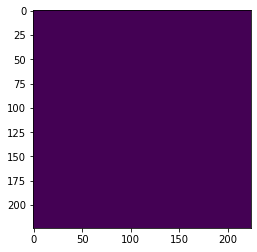

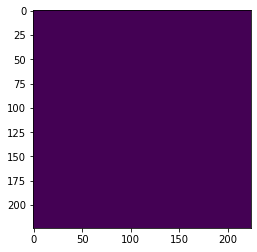

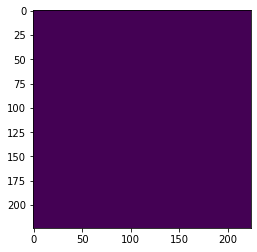

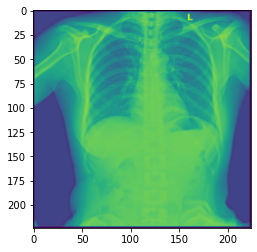

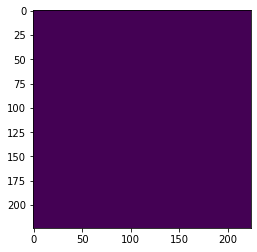

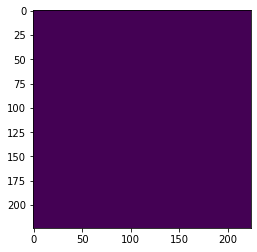

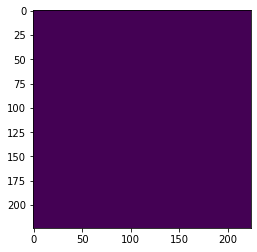

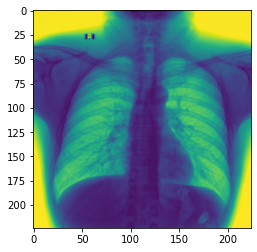

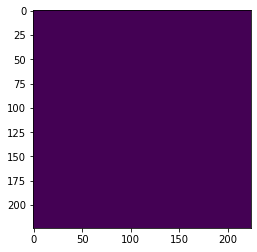

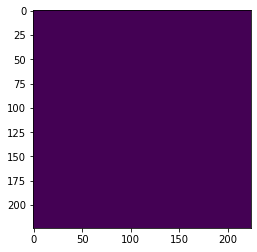

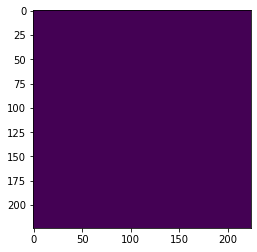

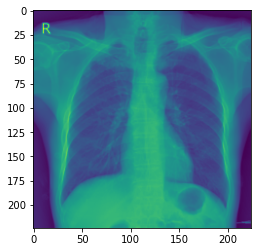

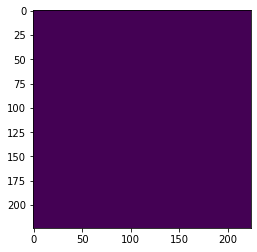

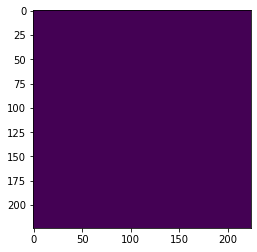

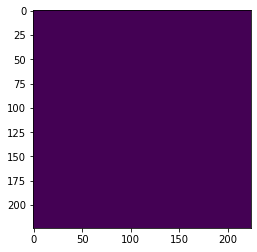

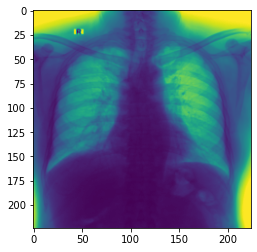

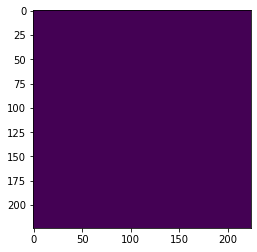

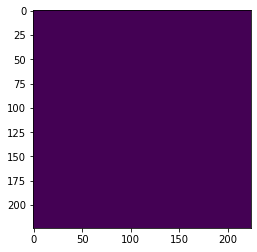

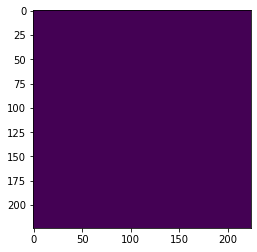

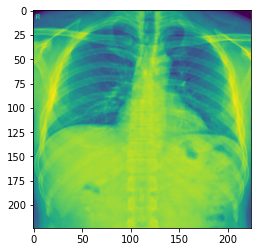

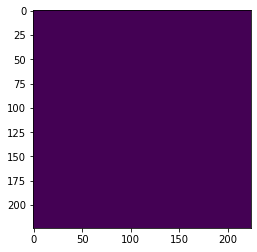

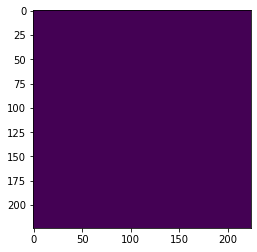

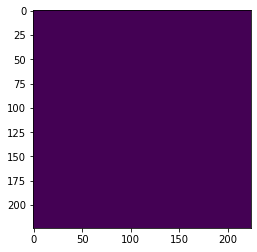

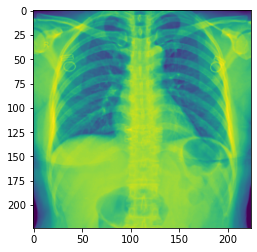

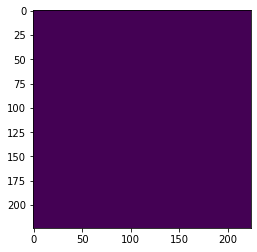

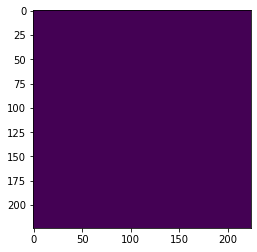

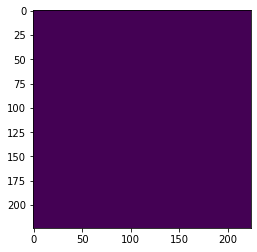

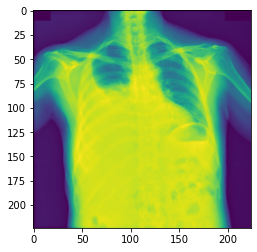

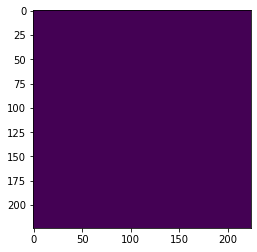

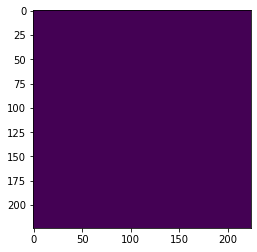

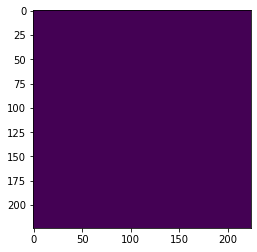

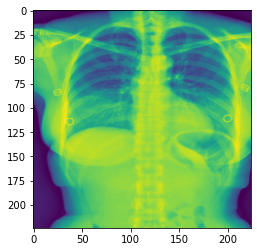

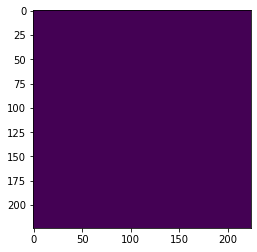

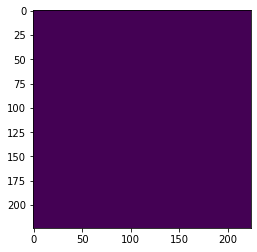

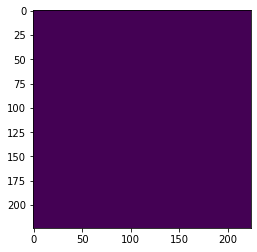

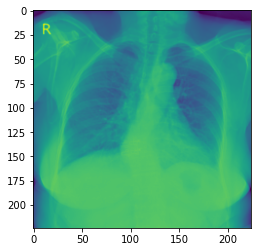

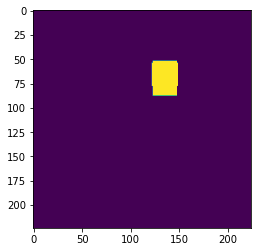

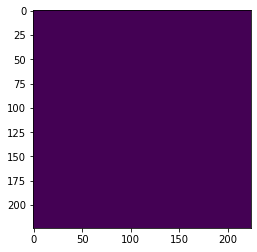

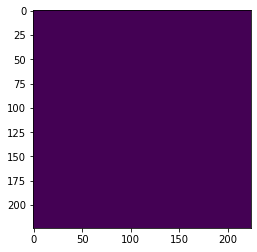

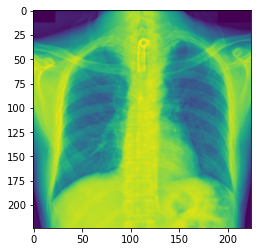

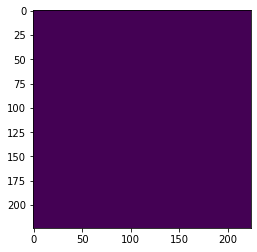

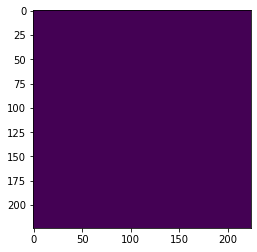

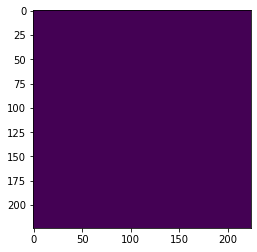

In [10]:
from matplotlib.patches import Rectangle
for k,kk in enumerate(traindata):
    plt.imshow(kk[0])
    for org in kk[1][3]:
        plt.gca().add_patch(Rectangle((org[0], org[1]), (org[2]-org[0]), (org[3]-org[1]),linewidth=1,edgecolor='b',facecolor='none'))
    plt.show()
    for j in kk[1][:3]:
        plt.imshow(j)
        plt.show()
    if k ==10:
        break

In [11]:
from collections import OrderedDict
import torch
import torch.nn as nn

class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=15, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [12]:
model_unet = UNet(in_channels=1, out_channels=15, init_features=32)
model_unet = model_unet.cuda()
calc = nn.MSELoss()
optimizer = optim.Adamax(model_unet.parameters(), lr=0.0003)

In [13]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [14]:
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

In [15]:
metrics = defaultdict(float)

In [ ]:
epochs = 1
steps = 0
print_every = 750
train_losses, train_accuracy = [], []
#model.load_state_dict(torch.load('./final_model.pth'))
for epoch in range(epochs):
    model_unet.train()
    size = 0
    running_loss = 0
    acc = 0
    for a,(image_train, y_train) in enumerate(data_loader):
        steps += 1
        image_train, y_train = image_train.unsqueeze(0).cuda(), y_train.cuda()
        image_train = Variable(image_train,requires_grad=True)
        optimizer.zero_grad()
        y_predtrain = model_unet.forward(image_train)
        #y_train=y_train.type(torch.LongTensor)
        #loss = calc_loss(y_predtrain, y_train,metrics)
        loss = calc(y_predtrain, y_train)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        ps = torch.exp(y_predtrain)
        top_p = torch.max(y_predtrain, 1)
        top_class = torch.argmax(y_predtrain,dim = 1)
        equals = top_class == y_train
        print(torch.mean(equals.type(torch.FloatTensor)).item())
        acc += torch.mean(equals.type(torch.FloatTensor)).item()
        size += image_train.shape[0]
        model_unet.eval()
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {running_loss/print_every:.3f}.. "
              f"Train accuracy: {acc/len(data_loader):.3f}")
    #torch.save(model.state_dict(),'./'+str(epoch)+'model.pth')
    #print('model saved')
    torch.save(model_unet.state_dict(),'./'+str(epoch)+'unet_model.pth')
    train_losses.append(float(running_loss)/float(size))
    train_accuracy.append(float(acc)/float(size))
    print('train_losses',epoch,train_losses)
    print('train_accuracy',epoch,train_accuracy)
torch.save(model_unet.state_dict(),'./final_unet_model.pth')
print('model saved')
print('train_losses',epoch,train_losses)
print('train_accuracy',epoch,train_accuracy)

0.08641581982374191
Epoch 1/1.. Train loss: 0.000.. Train accuracy: 0.000
0.0
Epoch 1/1.. Train loss: 0.001.. Train accuracy: 0.000
0.0
Epoch 1/1.. Train loss: 0.001.. Train accuracy: 0.000
0.0
Epoch 1/1.. Train loss: 0.001.. Train accuracy: 0.000
0.0
Epoch 1/1.. Train loss: 0.002.. Train accuracy: 0.000
0.0
Epoch 1/1.. Train loss: 0.002.. Train accuracy: 0.000
0.0
Epoch 1/1.. Train loss: 0.002.. Train accuracy: 0.000
0.0
Epoch 1/1.. Train loss: 0.003.. Train accuracy: 0.000
0.0
Epoch 1/1.. Train loss: 0.003.. Train accuracy: 0.000
0.0
Epoch 1/1.. Train loss: 0.003.. Train accuracy: 0.000
0.0
Epoch 1/1.. Train loss: 0.004.. Train accuracy: 0.000
0.0
Epoch 1/1.. Train loss: 0.004.. Train accuracy: 0.000
0.0
Epoch 1/1.. Train loss: 0.004.. Train accuracy: 0.000
0.0
Epoch 1/1.. Train loss: 0.005.. Train accuracy: 0.000
0.0
Epoch 1/1.. Train loss: 0.005.. Train accuracy: 0.000
0.0
Epoch 1/1.. Train loss: 0.005.. Train accuracy: 0.000
0.0
Epoch 1/1.. Train loss: 0.006.. Train accuracy: 0.00

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
lables = ['Aortic enlargement', 'Atelectasis','Calcification','Cardiomegaly','Consolidation','ILD','Infiltration','Lung Opacity','Nodule/Mass','Other lesion','Pleural effusion','Pleural thickening','Pneumothorax','Pulmonary fibrosis','No Findings']
cf_matrix = confusion_matrix(y_train, y_predtrain)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in lables],
                     columns = [i for i in lables])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')